## Generalised Object Detection using Keras and tensorflow as backend. 

By following this, you can develop Object Detection on any standard dataset or your own custom dataset for object detection. 

### Following is a Brief Study on Object Detection Methods and their `Pros` and `Cons` used before Faster RCNN.

## Method - 1
### Using CNNs

1. Take an image as input 
2. Divide it into regions
3. Consider each region as input to CNN
4. Classify each region into one of the classes


### Problems with the above approach

1. Regions can be of any aspect ratio
2. Objects can be of any shapes and sizes
3. Computationally expensive to calculate all these regions and objects and then to identify them

### So, to solve these problems and to reduce the number of regions, we use region-based CNNs(R-CNNs), which selects the regions using a proposal method.

## Method - 2
### RCNN

In this algorithm, we use **selective search** to propose bouding boxes in the image and identifies object in these regions. 


1. Convnet for extracting features.

2. Linear SVM classifier for identifying objects.

3. Regression for predicting correct bounding boxes.

### Problems with RCNN approach

1. Computationally expensive to compute 2K regions for each image.

2. Feature Extraction for every image region. If we have N images, then the number of Convet features will be N*2,000.

3. Haivng 3 steps (above mentioned) make RCNN very slow.


## Method - 3

### Fast RCNN

1. Image as input to a ConvNet which in turns generates the Regions of Interest.
2. A RoI pooling layer is applied on all of these regions to reshape them as per the input of the ConvNet.
3. These regions are passed to a classifier network having a **softmax layer** and a **linear regression layer** at its top, to classify and output the bounding boxes for objects in the given images.


### Problems with Fast RCNN approach

1. Fast RCNN also uses **selective search** as a proposal method to find the Regions of Interest, which is a slow and time consuming process. 
2. Fast RCNN takes around 2 seconds per image to detect objects, which is much better compared to RCNN which takes around 40-50 seconds. But when we consider large real-life datasets, then even a Fast RCNN doesn’t look so fast anymore.



## Method - 4

### Faster RCNN 
[Explanation](https://tryolabs.com/blog/2018/01/18/faster-r-cnn-down-the-rabbit-hole-of-modern-object-detection/)

Faster RCNN is the modified version of Fast RCNN. Faster RCNN uses “Region Proposal Network”(RPN). 

RPN takes image feature maps as an input and generates a set of object proposals.


1. Image is the input which is passed to a **Base Network** (Convnet) which gives the features for that images.

2. These features are input to **RPN**. RPN returns the object proposals.

3. **RoI pooling** is applied on these proposals to bring down all the proposals to the same size.

4. These proposals are passed to a classifier network having a **softmax layer** and a **linear regression layer** at its top, to classify and output the bounding boxes for objects in the given images.


#### Problems with Fatser RCNN approach

These networks use regions to identify the objects. They focus on parts of the image sequentially but not looking at the complete image in one go which has a scope for improvement.

1. To extract all the objects, Fatser RCNN requires many passes through an image . 
2. With haivng different networks within, the performance depends on how all these networks performed.

### Implementation of Faster RCNN

Files Required: https://drive.google.com/drive/folders/1lHZ90Zf-2iLDvgDRsgDpb29HTMDCOORP

Research Paper: https://arxiv.org/pdf/1506.01497.pdf

In [0]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import os

### Create a folder with name `keras_frcnn` and import the given files under this folder from google drive. 

In [0]:
mkdir keras_frcnn

In [3]:
import tensorflow as tf
import keras
from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from keras_frcnn import config, data_generators
from keras_frcnn import losses as losses
import keras_frcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [4]:
keras.__version__

'2.2.5'

In [5]:
tf.__version__

'1.14.0'

### Mount the drive to access the required files for the project

In [0]:
from google.colab import drive

In [7]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Replace the below path with your path in your drive accordingly. 

In [0]:
project_path = '/content/drive/My Drive/AIML Notes/ObjectDetection/'

In [0]:
data_filename = 'VOCtrainval_11-May-2012.tar'

In [0]:
weight_filename = 'resnet50_weights_tf_dim_ordering_tf_kernels.h5'

### Extract Images from the images and classes data file

In [0]:
import tarfile
tar = tarfile.open(project_path + data_filename)
tar.extractall()
tar.close()

In [12]:
from keras_frcnn.pascal_voc_parser import get_data
all_imgs, classes_count, class_mapping = get_data('./VOCdevkit')

Processing 2009_001199.xml:   0%|          | 27/17125 [00:00<01:03, 267.48it/s]

Parsing annotation files


Processing 2009_003644.xml: 100%|██████████| 17125/17125 [01:01<00:00, 277.35it/s]


### Different classes and counts in the dataset

In [13]:
classes_count ## no.of samples in the dataset belongs to a class

{'aeroplane': 954,
 'bicycle': 790,
 'bird': 1221,
 'boat': 999,
 'bottle': 1482,
 'bus': 637,
 'car': 2364,
 'cat': 1227,
 'chair': 2906,
 'cow': 702,
 'diningtable': 747,
 'dog': 1541,
 'horse': 750,
 'motorbike': 751,
 'person': 10129,
 'pottedplant': 1099,
 'sheep': 994,
 'sofa': 786,
 'train': 656,
 'tvmonitor': 826}

### Giving IDs to classes

In [14]:
class_mapping ## id to a class

{'aeroplane': 0,
 'bicycle': 18,
 'bird': 1,
 'boat': 14,
 'bottle': 15,
 'bus': 11,
 'car': 10,
 'cat': 4,
 'chair': 12,
 'cow': 19,
 'diningtable': 13,
 'dog': 7,
 'horse': 8,
 'motorbike': 17,
 'person': 5,
 'pottedplant': 16,
 'sheep': 9,
 'sofa': 6,
 'train': 2,
 'tvmonitor': 3}

### Sample Image Data having annotated information like class, bounding box coordinates, filename, height, width etc..

In [15]:
all_imgs[3] ## information for each image

{'bboxes': [{'class': 'tvmonitor',
   'difficult': False,
   'x1': 1,
   'x2': 135,
   'y1': 1,
   'y2': 144},
  {'class': 'cat',
   'difficult': False,
   'x1': 190,
   'x2': 479,
   'y1': 108,
   'y2': 326}],
 'filepath': './VOCdevkit/VOC2012/JPEGImages/2010_004816.jpg',
 'height': 375,
 'image_id': 5,
 'imageset': 'train',
 'width': 500}

### VIsualising a sample image

In [0]:
import cv2

In [0]:
img = cv2.imread('./VOCdevkit/VOC2012/JPEGImages/2008_002774.jpg')

In [18]:
img.shape

(500, 334, 3)

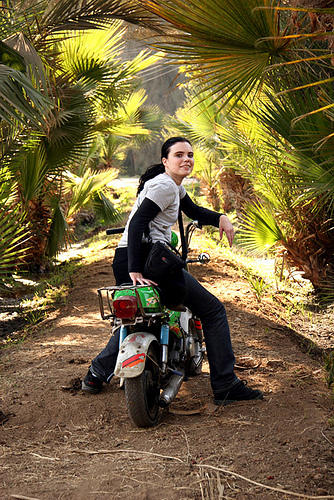

In [19]:
from google.colab.patches import cv2_imshow
cv2_imshow(img) ## 2 classes person, motorbike there in the image

### Adding background to the classes list

In [0]:
if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

In [21]:
print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))

Training images per class:
{'aeroplane': 954,
 'bg': 0,
 'bicycle': 790,
 'bird': 1221,
 'boat': 999,
 'bottle': 1482,
 'bus': 637,
 'car': 2364,
 'cat': 1227,
 'chair': 2906,
 'cow': 702,
 'diningtable': 747,
 'dog': 1541,
 'horse': 750,
 'motorbike': 751,
 'person': 10129,
 'pottedplant': 1099,
 'sheep': 994,
 'sofa': 786,
 'train': 656,
 'tvmonitor': 826}
Num classes (including bg) = 21


In [0]:
inv_map = {v: k for k, v in class_mapping.items()}

In [23]:
inv_map

{0: 'aeroplane',
 1: 'bird',
 2: 'train',
 3: 'tvmonitor',
 4: 'cat',
 5: 'person',
 6: 'sofa',
 7: 'dog',
 8: 'horse',
 9: 'sheep',
 10: 'car',
 11: 'bus',
 12: 'chair',
 13: 'diningtable',
 14: 'boat',
 15: 'bottle',
 16: 'pottedplant',
 17: 'motorbike',
 18: 'bicycle',
 19: 'cow',
 20: 'bg'}

### Shuffle all the images

In [0]:
random.shuffle(all_imgs)

num_imgs = len(all_imgs)

### Total no.of images in the dataset

In [25]:
num_imgs

11540

### As this is a competition dataset we don't have test data as a part of this. But for our purpose we can deal with these ~1000 images and their annotations. 

In [26]:
train_imgs = [s for s in all_imgs if s['imageset'] == 'train']
val_imgs = [s for s in all_imgs if s['imageset'] == 'val']
test_imgs = [s for s in all_imgs if s['imageset'] == 'test']

print('Num train samples {}'.format(len(train_imgs)))
print('Num val samples {}'.format(len(val_imgs)))
print('Num test samples {}'.format(len(test_imgs)))

Num train samples 5717
Num val samples 5823
Num test samples 0


### Importing base network `Resnet` for extracting features from the image

In [0]:
from keras_frcnn import resnet as nn

In [0]:
input_shape_img = (None, None, 3)

In [30]:
img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(None, 4))

### Base network, the feature extractor

In [31]:
shared_layers = nn.nn_base(img_input, trainable=True)

### Parameters for Region Proposal Network (RPN) 

In [32]:
# define the RPN, built on the base layers
anchor_box_scales = [128, 256, 512]

# anchor box ratios
anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]
    
num_anchors = len(anchor_box_scales) * len(anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

### Detection network

In [33]:
num_rois = 300
classifier = nn.classifier(shared_layers, roi_input, num_rois, nb_classes=len(classes_count), trainable=True)

### Model having RPN and the Classifier

In [0]:
model_rpn = Model(img_input, rpn[:2])
model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
model_all = Model([img_input, roi_input], rpn[:2] + classifier)

### Loading weights to the base network

In [35]:
base_net_weights = nn.get_weight_path()
base_net_weights = project_path + base_net_weights
print('loading weights from {}'.format(base_net_weights))
model_rpn.load_weights(base_net_weights, by_name=True)
model_classifier.load_weights(base_net_weights, by_name=True)

loading weights from /content/drive/My Drive/AIML Notes/ObjectDetection/resnet50_weights_tf_dim_ordering_tf_kernels.h5



### Training

In [0]:
optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)

In [37]:
model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
model_all.compile(optimizer='sgd', loss='mae')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Parameters for training

In [0]:
epoch_length = 200
num_epochs = 3
num_epochs = int(num_epochs)
iter_num = 0
train_step = 0

In [0]:
losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

In [40]:
best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}
print('Starting training')

Starting training


### For the ease in coding purpose to access a dictionary

We can now access a key in a dict using dot(dict.key) instead of dict["key"]

In [41]:
pip install dotted-dict

In [0]:
from dotted_dict import DottedDict

In [0]:
C = DottedDict({"balanced_classes": False,
     "im_size": 600,
     "anchor_box_scales": [128, 256, 512],
     "anchor_box_ratios": [[1, 1], [1, 2], [2, 1]],
     "rpn_stride": 16,
     "rpn_max_overlap": 0.7,
     "rpn_min_overlap": 0.3,
     "img_channel_mean": [103.939, 116.779, 123.68],
     "img_scaling_factor": 1.0,
     "std_scaling": 4.0,
     "verbose": 1,
     "use_horizontal_flips": False,
     "use_vertical_flips": False,
     "model_path" : 'model_frcnn.resnet.hdf5',
     "num_rois": 300,
     "classifier_min_overlap": 0.1,
     "classifier_max_overlap": 0.5,
     "classifier_regr_std": [8.0, 8.0, 4.0, 4.0]
    })

### Data Generators having data augmentation also in the given files under `keras_frcnn` folder

In [0]:
data_gen_train = data_generators.get_anchor_gt(train_imgs, classes_count, C, nn.get_img_output_length, K.common.image_dim_ordering(), mode='train')
data_gen_val = data_generators.get_anchor_gt(val_imgs, classes_count, C, nn.get_img_output_length, K.common.image_dim_ordering(), mode='val')
data_gen_test = data_generators.get_anchor_gt(test_imgs, classes_count, C, nn.get_img_output_length, K.common.image_dim_ordering(), mode='val')

### Epochs

1) Training RPN and getting the predictions from RPN.

2) ROI Pooling

3) Detection network having classification and bounding box regression loss fucntions to make predictions.

Note: RPN losses and Classifier losses are mentioned for each epoch.

In [45]:
iter_num = 0
for epoch_num in range(num_epochs):
    progbar = generic_utils.Progbar(epoch_length)   # keras progress bar
    print('\nEpoch {}/{}'.format(epoch_num + 1, num_epochs))
    while True:
            X, Y, img_data = next(data_gen_train)

            loss_rpn = model_rpn.train_on_batch(X, Y)
        
            P_rpn = model_rpn.predict_on_batch(X)

            R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.common.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            # sampling positive/negative samples
            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))


            if C.num_rois > 1:
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])


            train_step += 1
            
            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            losses[iter_num, 2] = loss_class[1]
            losses[iter_num, 3] = loss_class[2]
            losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])),
                                      ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                loss_class_cls = np.mean(losses[:, 2])
                loss_class_regr = np.mean(losses[:, 3])
                class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    print('Loss Detector classifier: {}'.format(loss_class_cls))
                    print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))

                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                break


Epoch 1/3
200/200 [==============================] - 532s 3s/step - rpn_cls: 4.3843 - rpn_regr: 0.2289 - detector_cls: 1.1948 - detector_regr: 0.4401
Mean number of bounding boxes from RPN overlapping ground truth boxes: 12.960199004975124
Classifier accuracy for bounding boxes from RPN: 0.951683332324028
Loss RPN classifier: 3.2998500935993977
Loss RPN regression: 0.23359379489906132
Loss Detector classifier: 0.5750613242725376
Loss Detector regression: 0.44020348995923997
Elapsed time: 539.703910112381
Total loss decreased from inf to 4.548708702730236, saving weights

Epoch 2/3
200/200 [==============================] - 456s 2s/step - rpn_cls: 2.7383 - rpn_regr: 0.2109 - detector_cls: 0.2987 - detector_regr: 0.4226
Mean number of bounding boxes from RPN overlapping ground truth boxes: 13.88
Classifier accuracy for bounding boxes from RPN: 0.9537333318591118
Loss RPN classifier: 2.540652797041039
Loss RPN regression: 0.20127734933048486
Loss Detector classifier: 0.2870000974088907
L

#### After training for no.of epochs like 1000-2000 with epoch length having ~1000 images, then we can have reasonable accuracy in detecting the objects in the given images for testing. 

Note: Sample images with predictions like bounding boxes and classes are given in the drive link for your reference.  